# Data definition

In [79]:
import numpy as np
from scipy.spatial.distance import cdist
from numba import jit
from functools import lru_cache

def distances(samples, distance=lambda x,y: np.sum(np.abs(x-y))):
    ret = [0 for i in range(samples.shape[1])]
    for i in range(samples.shape[1]):
        print(i)
        ret[i] = np.array([np.sum(list(map(distance, samples[:,i], samples[:,j]))) for j in range((samples.shape[1]))])
    return np.array(ret)
def local_fitness(order, dists, row, col):
    directions = ((1,1), (1,0), (0,1), (1,-1), (0,-1), (-1,1), (-1,0), (-1,-1))
    ret = 0
    for x0, y0 in directions:
        if    (row + x0 < 0 or row + x0 >= order.shape[0]
            or col + y0 < 0 or col + y0 >= order.shape[1]):
            continue
        ret += dists[order[row + x0, col + y0], order[row, col]]
    return ret

# @jit(nopython=True)
def fitness(order, dists, rows, columns):
    ret = 0
    order = np.array(order).reshape(rows, columns)    
    for i in range(rows):
        for j in range(columns):
            for k in range(rows):
                for l in range(columns):
                    point_distance = np.sqrt(np.square(i-j) + np.square(k-l)) + 1e-6
                    value_distance = dists[order[i,j], order[k,l]]
                    ret += value_distance/point_distance
    return ret,

def generate_samples(n_samples, dimensions, base_params=None, noise_var=1):
    if base_params==None:
        base_params = (dimensions//10 )+ 1
    samples = []
    base_samples = []
    distances = []
    labels = []
    zeros = np.zeros(base_params)
    corrs = np.random.normal(0,1, base_params)
    corrs_with = np.random.randint(0, base_params, size=dimensions)
    for i in range(n_samples):
        sample_base = np.random.normal(0,1, base_params)
        base_samples.append(sample_base)
        sample = np.array([corrs[i]*sample_base[i] for i in corrs_with])
        distances.append(np.sum(np.square(zeros-sample_base)))
        samples.append(sample)
    quater1 = np.quantile(distances,0.25)
    quater3 = np.quantile(distances,0.75)
    for i in range(n_samples):
        labels.append(
                distances[i]+np.random.normal(0, noise_var) > quater1
            and
                distances[i]+np.random.normal(0, noise_var) < quater3)
    return np.array(samples), np.array(labels)
    


Don't generate, use pregenerated:

In [4]:
SIDE_SIZE = 30
samples = np.load("samples.npy")
labels = np.load("labels.npy")
dists = np.load("dists.npy")

Generate:

In [ ]:
# SIDE_SIZE = 30
# print("Generating...")
# samples, labels = generate_samples(1000, SIDE_SIZE**2, noise_var=1)
# print("Calculating distances...")
# dists =distances(samples)
# print("Done")

Save generated data:

In [234]:
# np.save("samples.npy", samples)
# np.save("labels.npy", labels)
# np.save("dists.npy", dists)

# Evolutionary optimization

In [33]:
import array
import random
import numpy as np
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools


IND_SIZE = SIDE_SIZE*SIDE_SIZE
rows=SIDE_SIZE
columns=SIDE_SIZE
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(IND_SIZE), IND_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", lambda x: fitness(x, dists, rows, columns))
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=2000, 
                               stats=stats, halloffame=hof, verbose=True)

C:\Users\souku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\souku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg       	std   	min        	max        
0  	300   	5.4963e+07	723543	5.33014e+07	5.68518e+07
1  	178   	5.45778e+07	682554	5.28564e+07	5.68232e+07
2  	170   	5.43439e+07	686058	5.28194e+07	5.67776e+07
3  	186   	5.41778e+07	725911	5.25775e+07	5.69291e+07
4  	179   	5.41408e+07	816464	5.2547e+07 	5.63558e+07
5  	174   	5.39381e+07	820009	5.20129e+07	5.65053e+07
6  	187   	5.3753e+07 	819028	5.20129e+07	5.62887e+07
7  	171   	5.36051e+07	895001	5.20129e+07	5.65426e+07
8  	186   	5.36316e+07	991517	5.20129e+07	5.68061e+07
9  	183   	5.35773e+07	1.03778e+06	5.20129e+07	5.68848e+07
10 	200   	5.36935e+07	990240     	5.20129e+07	5.61345e+07
11 	176   	5.35096e+07	1.01754e+06	5.20129e+07	5.6273e+07 
12 	166   	5.33687e+07	992191     	5.19788e+07	5.65648e+07
13 	189   	5.33138e+07	1.03265e+06	5.19788e+07	5.70528e+07
14 	178   	5.33121e+07	1.11413e+06	5.17882e+07	5.68896e+07
15 	195   	5.33363e+07	1.13474e+06	5.17882e+07	5.61741e+07
16 	184   	5.32258e+07	1.09619e+06	5.17685e+07	5.

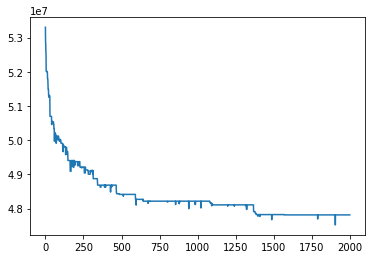

In [34]:
import matplotlib.pyplot as plt
mins = [x["min"] for x in log]
plt.plot(mins)
plt.show()

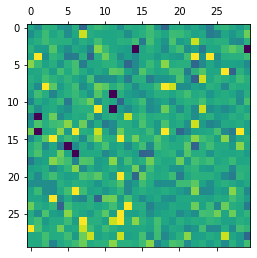

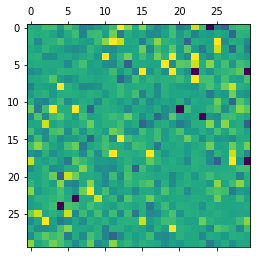

In [118]:
# np.save("result.npy",np.array(hof.items) )
i=2
plt.matshow(samples[i].reshape((SIDE_SIZE,SIDE_SIZE)))
plt.show()
# plt.matshow(samples[:,np.array(hof.items).reshape(SIDE_SIZE**2)][i].reshape((SIDE_SIZE,SIDE_SIZE)))
# plt.show()
plt.matshow(samples[i][hof.best_individual.reshape(1,900)].reshape((SIDE_SIZE,SIDE_SIZE)))
plt.show()

In [114]:
samples[0]

array([-4.94816016e-01,  9.39200249e-01,  7.72144281e-02,  5.39673263e-02,
        4.05884702e-01,  7.23025524e-01, -1.62929256e-03, -1.54296138e+00,
       -1.88115138e-01, -1.34628881e-01, -6.08043491e-01,  7.75455014e-03,
        9.39200249e-01, -7.07256123e-01, -2.01393066e-02,  8.87283377e-02,
       -7.30918705e-01,  4.05884702e-01, -1.54296138e+00,  7.75455014e-03,
        2.24161332e-01,  2.17087250e+00, -3.39336294e-01,  1.12208392e-01,
        1.17365662e+00,  1.11629093e+00, -7.86135169e-02,  2.55794794e-02,
        1.33642105e+00, -1.62929256e-03, -2.16586945e-01, -2.45286046e-02,
       -6.70660596e-01,  8.82670458e-02,  1.11629093e+00,  9.39200249e-01,
       -4.94816016e-01, -4.52281092e+00,  2.85925704e-01, -3.39336294e-01,
        1.42894084e-01, -2.45286046e-02, -2.49502285e+00,  9.39200249e-01,
       -2.49502285e+00, -1.31022579e-01, -6.70660596e-01,  4.58061131e-01,
        8.82670458e-02,  1.54567523e+00, -1.34628881e-01,  1.09889540e-01,
        1.24813717e+00, -

In [27]:
fitness(o, dists, rows, columns)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(array(int32, 2d, C))
 
There are 4 candidate implementations:
[1m  - Of which 4 did not match due to:
  Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba\core\overload_glue.py: Line 131.
    With argument(s): '(array(int32, 2d, C))':[0m
[1m   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   [1m[1m[1mNo implementation of function Function(<intrinsic stub>) found for signature:
    
    >>> stub(array(int32, 2d, C))
    
   There are 2 candidate implementations:
   [1m  - Of which 2 did not match due to:
     Intrinsic in function 'stub': File: numba\core\overload_glue.py: Line 35.
       With argument(s): '(array(int32, 2d, C))':[0m
   [1m   Rejected as the implementation raised a specific error:
        TypingError: [1marray(int32, 2d, C) not allowed in a homogeneous sequence[0m[0m
     raised from C:\Users\souku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numba\core\typing\npydecl.py:487
   [0m
   [0m[1mDuring: resolving callee type: Function(<intrinsic stub>)[0m
   [0m[1mDuring: typing of call at <string> (3)
   [0m
   [1m
   File "<string>", line 3:[0m
   [1m<source missing, REPL/exec in use?>[0m
[0m
  raised from C:\Users\souku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numba\core\typeinfer.py:1074
[0m
[0m[1mDuring: resolving callee type: Function(<built-in function array>)[0m
[0m[1mDuring: typing of call at C:\Users\souku\AppData\Local\Temp\ipykernel_5316\1894446032.py (26)
[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_5316\1894446032.py", line 26:[0m
[1m<source missing, REPL/exec in use?>[0m


In [31]:
o.shape

(1, 900)

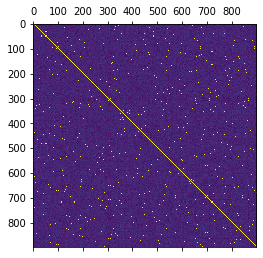

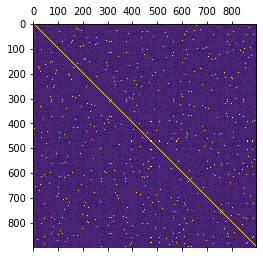

In [36]:
o = np.load("result.npy")
cm = np.corrcoef(samples[:,o[0]].T)
plt.matshow(cm)
plt.show()
cm = np.corrcoef(samples.T)
plt.matshow(cm)
plt.show()


In [256]:
o

array([281,  42, 167, 166, 485, 274, 665, 647, 826, 332, 152, 168, 585,
       871, 156, 409, 285, 668, 353, 119, 795, 495,  24, 593, 779, 323,
       272, 670, 117, 244, 426, 886, 839, 118, 813, 787, 573, 780, 213,
       159, 286,  36, 200,  88, 873, 214, 827, 330, 511, 501, 602, 530,
       205, 874, 563, 247, 619, 698, 369, 440, 570,  49, 596, 333, 141,
       789,  20, 356, 185, 866, 890,  64,  12, 894, 299, 812, 457, 849,
       814, 267, 663,   4, 875, 618, 340, 269, 300, 331, 378, 136, 656,
       402,  75, 121,  23, 714, 479, 567, 262, 709, 881, 294,  17, 482,
       774, 545, 187, 468, 694, 566, 796, 887, 201,  48, 742, 376, 251,
       290, 175, 364, 817, 401, 428, 276, 686, 149, 212, 758, 580, 806,
        91, 861, 713, 209, 591,   0, 836,  29,  59, 224,  61,  72, 576,
       465, 547, 298, 504, 352, 162, 610, 680, 484, 455, 229, 383, 494,
       412, 241, 642, 896, 705, 743, 206,  21, 321, 536, 473, 387, 639,
       296,  85, 844, 895, 794, 235, 297, 114, 733, 888, 790, 78

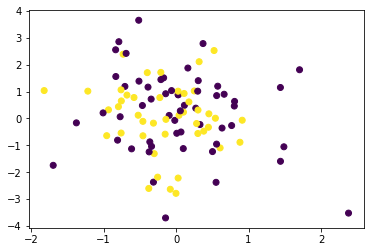

In [152]:
import matplotlib.pyplot as plt
samples, labels = generate_samples(100, 81, noise_var=1)
plt.scatter(samples[:,0], samples[:,1], c=labels)
plt.show()

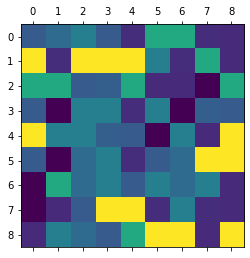

In [160]:
plt.matshow(distances(samples))
plt.show()

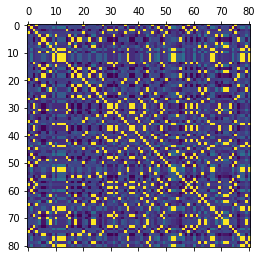

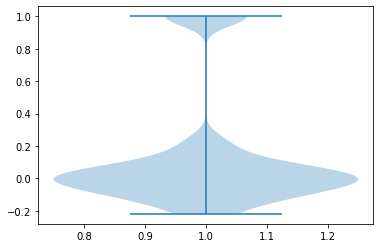

In [158]:
cm = np.corrcoef(samples.T)
plt.matshow(cm)
plt.show()
b = cm.flatten()
plt.violinplot(b)
plt.show()

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8


IndexError: index 9 is out of bounds for axis 1 with size 9

# HillClimbing

In [120]:
class HOF:
    def __init__(self, logging_freq=10, verb=True):
        self.hashC=211
        self.logging_freq=logging_freq
        self.verb = verb
        self.generation = 0        
        self.fitnesses = []
        self.generations = []
        self.searched = dict()
        self.best_fitness = float("infinity")
        self.best_individual = None
    def add(self, individual, fitness):
        hashed = self.hash(individual)
        if hashed in self.searched:
            return False
        self.searched[hashed]=fitness
        if self.best_fitness>fitness:
            self.best_fitness = fitness
            self.best_individual = individual
            self.fitnesses.append(fitness)
            self.generations.append(self.generation)
            if self.verb:
                print(self.generation, "\t", self.best_fitness)
        elif self.generation%self.logging_freq==0:
            self.fitnesses.append(fitness)
            self.generations.append(self.generation)
            if self.verb:
                print(self.generation, "\t", self.best_fitness)
        self.generation+=1
        return True
    def hash(self, individual):
        ret=0
        for i in range(individual.shape[0]):
            ret+=i*individual[i]*self.hashC
        return ret
    

def neighbours(individual, x, y, rows, columns):
    directions = ((1,1), (1,0), (0,1), (1,-1), (0,-1), (-1,1), (-1,0), (-1,-1))    
    order = np.array(individual).reshape(rows, columns)
    ret = []
    for dx, dy in directions:
        movedx, movedy = x+dx, y+dy
        if movedx<0 or movedx >= rows or movedy<0 or movedy>=columns:
            continue
        new_order = order.copy()
        new_order[[x,x+dx], [y,y+dy]]=new_order[[x+dx,x], [y+dy,y]]
        ret.append(new_order.flatten())
    return ret

def HCA1(individual, fitness, neighbours, rows, columns, hof):
    my_fitness = fitness(individual)[0]
    if not hof.add(individual, my_fitness):
        return
    for x in range(rows):
        for y in range(columns):
            for n in neighbours(individual, x,y,rows,columns):
                if fitness(n)[0] < hof.best_fitness:
                    HCA1(n, fitness, neighbours, rows, columns, hof)


            
    


In [119]:
best = hof.best_individual

In [121]:
my_start = o.flatten()
hof = HOF()
HCA1(best, lambda x: fitness(x, dists, rows, columns), neighbours, rows, columns, hof)

C:\Users\souku\AppData\Local\Temp\ipykernel_5316\2915713369.py:34: RuntimeWarning: overflow encountered in long_scalars
  ret+=i*individual[i]*self.hashC


0 	 47302380.947339535
1 	 47297577.92144119
2 	 47293403.14020753
3 	 47293403.14020752
4 	 47292616.83193537
5 	 47292616.83193536
6 	 47289384.10339814
7 	 47286834.38842304
8 	 47286834.38842303
9 	 47284038.167290404
10 	 47281762.89433977
11 	 47279110.37396074
12 	 47276341.44966982
13 	 47273541.87515723
14 	 47271166.455669634
15 	 47268325.48881823
16 	 47266009.24972096
17 	 47265593.81767863
18 	 47265593.81767862
19 	 47265434.65188733
20 	 47265163.18877501
21 	 47264606.527035266
22 	 47264606.52703526
23 	 47264606.52703525
24 	 47263662.954484604
25 	 47263662.9544846
26 	 47261726.3640418
27 	 47261726.36404179
28 	 47260584.327706374
29 	 47259946.48084361
30 	 47259420.29036817
31 	 47259037.36454059
32 	 47258932.90703564
33 	 47258932.907035634
34 	 47257965.3015026
35 	 47257965.301502585
36 	 47257965.30150258
37 	 47255425.035366535
38 	 47253670.65471972
39 	 47253670.65471971
40 	 47252282.095792696
41 	 47251693.651026286
42 	 47250972.78015177
43 	 47247045

In [102]:
hof.best_individual


(1, 900)

# Evaluation

In [103]:
orig_X = np.array([i.reshape(SIDE_SIZE,SIDE_SIZE,1) for i in samples])
X = np.array([i[o].reshape(SIDE_SIZE,SIDE_SIZE,1) for i in samples])
climbed_X = np.array([i[hof.best_individual.reshape(1,900)].reshape(SIDE_SIZE,SIDE_SIZE,1) for i in samples])
y = labels

In [41]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import linear, relu
from tensorflow.nn import softmax


In [59]:
def create_model(): 
    model = tf.keras.models.Sequential([])
    model.add(InputLayer(input_shape = (SIDE_SIZE, SIDE_SIZE,1)))
    model.add(Conv2D(filters=5, kernel_size=(5, 5), activation=relu))
    model.add(MaxPool2D(strides=2, pool_size=(2, 2)))
    # model.add(Conv2D(filters=64, kernel_size=5, activation=relu))
    # model.add(MaxPool2D(strides=2, pool_size=(2, 2)))
    model.add(Flatten(name='Flatten'))
    # model.add(Dense(units=32, activation=relu))
    model.add(Dense(units=1, name='logits', activation="sigmoid"))
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [106]:
refined_model = create_model()
refined_callbacks = refined_model.fit(X,y, epochs=100)
orig_model = create_model()
orig_callbacks = orig_model.fit(orig_X,y, epochs=100)
climbed_model = create_model()
climbed_callbacks = climbed_model.fit(climbed_X,y, epochs=100)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 5)         130       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 5)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 845)               0         
_________________________________________________________________
logits (Dense)               (None, 1)                 846       
Total params: 976
Trainable params: 976
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 0.7494 - accuracy: 0.5160
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7099 - accuracy: 0.5190
Epoch 3/100
32/32 [==============================]

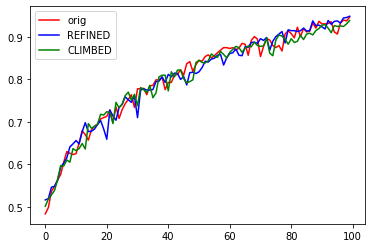

In [107]:
plt.plot(orig_callbacks.history["accuracy"], c="r", label="orig")
plt.plot(refined_callbacks.history["accuracy"], c="b", label="REFINED")
plt.plot(climbed_callbacks.history["accuracy"], c="g", label="CLIMBED")
plt.legend()
plt.show()